Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\whovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [01:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


최적의 하이퍼파라미터:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 17, 'classifier__n_estimators': 700, 'classifier__reg_lambda': 1.5}
Validation Accuracy: 0.89
Validation F1 Score: 0.94
Test Accuracy: 0.9003
Test F1 Score: 0.9424

테스트 데이터에 대한 분류 보고서:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       900
           1       0.94      0.94      0.94      5700

    accuracy                           0.90      6600
   macro avg       0.79      0.78      0.79      6600
weighted avg       0.90      0.90      0.90      6600



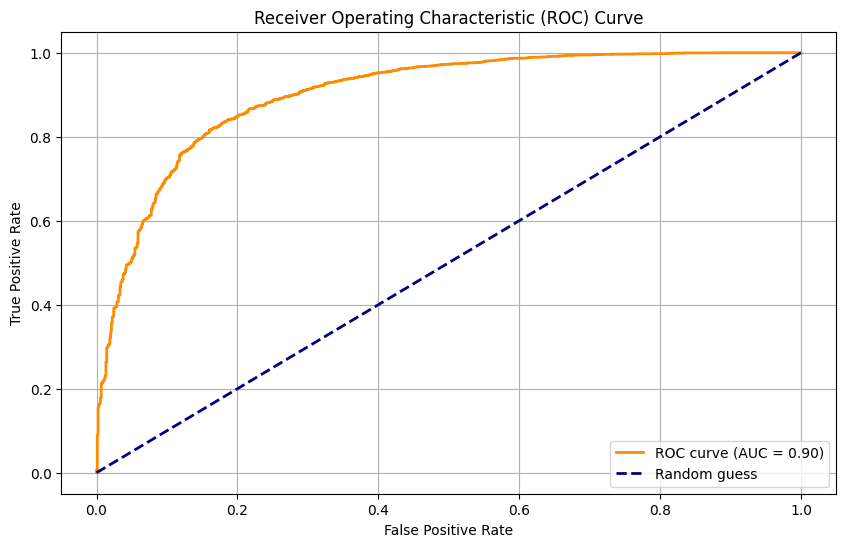

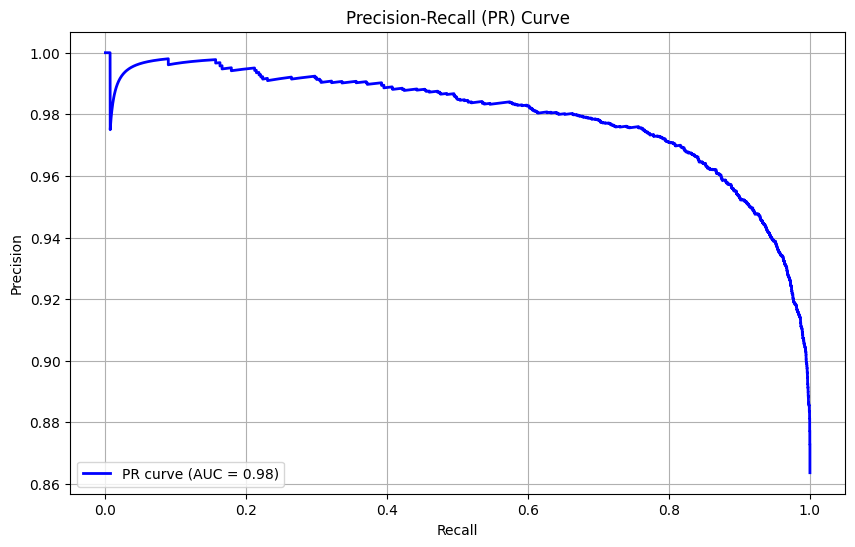

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# 1. 데이터 로드
data = pd.read_csv("../monunmon.csv")  # 데이터셋 경로 입력
data['Label'] = data['Label'].apply(lambda x: 1 if x >= 0 else 0)  # 이진 레이블 변환

# 2. 특성과 레이블 분리
X = data.drop(columns=['Label'])  # 피처 데이터
y = data['Label']  # 레이블 데이터

# 3. 데이터 나누기
# 3. 데이터 나누기: 훈련, 검증, 테스트 데이터셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)  # 테스트 30%, 나머지 훈련+검증 70%

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)  # 검증 20% (전체의 14%)


# 4. 파이프라인 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False))
])

# 5. 간단한 하이퍼파라미터 그리드 정의
param_grid = {
    'classifier__n_estimators': [700],  # 트리 개수
    'classifier__max_depth': [15, 17],         # 트리의 최대 깊이
    'classifier__learning_rate': [0.1],
    'classifier__reg_lambda':[1.5]      # 학습률
}

# 6. 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 7. GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 8. 모델 학습
grid_search.fit(X_train, y_train)

# 9. 베스트 모델 추출
best_model = grid_search.best_estimator_
print("최적의 하이퍼파라미터: ", grid_search.best_params_)

# 검증 데이터 평가
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation F1 Score: {val_f1:.2f}")

# 10. 테스트 데이터 평가
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# 11. 분류 보고서 출력
print("\n테스트 데이터에 대한 분류 보고서:")
print(classification_report(y_test, y_test_pred))

# 12. ROC 커브 및 AUC 계산
y_test_prob = best_model.predict_proba(X_test)[:, 1]  # 양성 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 13. PR 커브 및 AUC 계산
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid()
plt.show()

